# Problem Set 4
Designed by Ben Usman, Kun He, and Sarah Adel Bargal, with help from Kate Saenko and Brian Kulis.

This assignment will introduce you to:
1. Building and training a convolutional network
2. Saving snapshots of your trained model
3. Reloading weights from a saved model
4. Fine-tuning a pre-trained network
5. Visualizations using Tensorboard

This code has been tested and should for Python 3.5 and 2.7 with tensorflow 1.0.*. Since recently, you can update to recent tensorflow version just by doing `pip install tensorflow`,  or `pip install tensorflow-gpu` if you want to use GPU.

**Note:** This notebook contains problem descriptions and demo/starter code. However, you're welcome to implement and submit .py files directly, if that's easier for you. Starter .py files are provided in the same `pset4/` directory.

## Part 0: Tutorials

You will find these TensorFlow tutorials on CNNs useful:
 - [Deep MNIST for experts](https://www.tensorflow.org/get_started/mnist/pros)
 - [Convolutional Neural Networks](https://www.tensorflow.org/tutorials/deep_cnn)
 
Note that there are many ways to implement the same thing in TensorFlow, for example, both tf.nn and tf.layers provide convolutional layers but with slightly different interfaces. You will need to read the documentation of the functions provided below to understand how they work.

## Part 1: Building and Training a ConvNet on SVHN
(25 points)

First we provide demo code that trains a convolutional network on the [SVHN Dataset](http://ufldl.stanford.edu/housenumbers/).. 

You will need to download   __Format 2__ from the link above.
- Create a directory named `svhn_mat/` in the working directory. Or, you can create it anywhere you want, but change the path in `svhn_dataset_generator` to match it.
- Download `train_32x32.mat` and `test_32x32.mat` to this directory.
- `extra_32x32.mat` is NOT needed.
- You may find the `wget` command useful for downloading on linux. 



The following defines a generator for the SVHN Dataset, yielding the next batch every time next is invoked.

In [3]:
import copy
import os
import math
import numpy as np
import scipy
import scipy.io

from six.moves import range

import read_data

@read_data.restartable
def svhn_dataset_generator(dataset_name, batch_size):
    assert dataset_name in ['train', 'test']
    assert batch_size > 0 or batch_size == -1  # -1 for entire dataset
    
    path = './svhn_mat/' # path to the SVHN dataset you will download in Q1.1
    file_name = '%s_32x32.mat' % dataset_name
    file_dict = scipy.io.loadmat(os.path.join(path, file_name))
    X_all = file_dict['X'].transpose((3, 0, 1, 2))
    y_all = file_dict['y']
    data_len = X_all.shape[0]
    batch_size = batch_size if batch_size > 0 else data_len
    
    X_all_padded = np.concatenate([X_all, X_all[:batch_size]], axis=0)
    y_all_padded = np.concatenate([y_all, y_all[:batch_size]], axis=0)
    y_all_padded[y_all_padded == 10] = 0
    
    for slice_i in range(int(math.ceil(data_len / batch_size))):
        idx = slice_i * batch_size
        X_batch = X_all_padded[idx:idx + batch_size]
        y_batch = np.ravel(y_all_padded[idx:idx + batch_size])
        yield X_batch, y_batch

The following defines the CovNet Model. It has two identical conv layers with 32 5x5 convlution filters, followed by a fully-connected layer to output the logits.

In [5]:
import tensorflow as tf

def cnn_map(x_):
    conv1 = tf.layers.conv2d(
            inputs=x_,
            filters=32,  # number of filters
            kernel_size=[5, 5],
            padding="same",
            activation=tf.nn.relu,name = 'conv1')
    
    pool1 = tf.layers.max_pooling2d(inputs=conv1, 
                                    pool_size=[2, 2], 
                                    strides=2)  # convolution stride
    
    conv2 = tf.layers.conv2d(
            inputs=pool1,
            filters=32, # number of filters
            kernel_size=[5, 5],
            padding="same",
            activation=tf.nn.relu)
    
    pool2 = tf.layers.max_pooling2d(inputs=conv2, 
                                    pool_size=[2, 2], 
                                    strides=2)  # convolution stride
        
    pool_flat = tf.contrib.layers.flatten(pool2, scope='pool2flat')
    dense = tf.layers.dense(inputs=pool_flat, units=500, activation=tf.nn.relu)
    logits = tf.layers.dense(inputs=dense, units=10)
    return logits


def apply_classification_loss(model_function):
    with tf.Graph().as_default() as g:
        with tf.device("/gpu:0"):  # use gpu:0 if on GPU
            x_ = tf.placeholder(tf.float32, [None, 32, 32, 3],name='x_input')
            y_ = tf.placeholder(tf.int32, [None],name='y_input')
            y_logits = model_function(x_)
            
            y_dict = dict(labels=y_, logits=y_logits)
            losses = tf.nn.sparse_softmax_cross_entropy_with_logits(**y_dict)
            with tf.name_scope("xent"):
                cross_entropy_loss = tf.reduce_mean(losses)
            trainer = tf.train.AdamOptimizer()            
            train_op = trainer.minimize(cross_entropy_loss)
            
            y_pred = tf.argmax(tf.nn.softmax(y_logits), dimension=1)
            with tf.name_scope("accuracy1"):
                correct_prediction = tf.equal(tf.cast(y_pred, tf.int32), y_)
                accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
                
    
    model_dict = {'graph': g, 'inputs': [x_, y_], 'train_op': train_op,
                  'accuracy': accuracy, 'loss': cross_entropy_loss}
    
    return model_dict
print(1)

1


### Q1.2 Training SVHN Net
Now we train a `cnn_map` net on Format 2 of the SVHN Dataset. We will call this "SVHN net". 

**Note:** training will take a while, so you might want to use GPU.

In [6]:
def train_model(model_dict, dataset_generators, epoch_n, print_every):
    with model_dict['graph'].as_default(), tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        
        for epoch_i in range(epoch_n):
            for iter_i, data_batch in enumerate(dataset_generators['train']):
                train_feed_dict = dict(zip(model_dict['inputs'], data_batch))
                sess.run(model_dict['train_op'], feed_dict=train_feed_dict)
                
                if iter_i % print_every == 0:
                    collect_arr = []
                    for test_batch in dataset_generators['test']:
                        test_feed_dict = dict(zip(model_dict['inputs'], test_batch))
                        to_compute = [model_dict['loss'], model_dict['accuracy']]
                        collect_arr.append(sess.run(to_compute, test_feed_dict))
                    averages = np.mean(collect_arr, axis=0)
                    fmt = (epoch_i, iter_i, ) + tuple(averages)
                    print('epoch {:d} iter {:d}, loss: {:.3f}, '
                          'accuracy: {:.3f}'.format(*fmt))

In [27]:
dataset_generators = {
        'train': svhn_dataset_generator('train', 256),
        'test': svhn_dataset_generator('test', 256)
}
    
model_dict = apply_classification_loss(cnn_map)
train_model(model_dict, dataset_generators, epoch_n=100, print_every=50)

epoch 0 iter 0, loss: 102.080, accuracy: 0.098
epoch 0 iter 50, loss: 2.139, accuracy: 0.267
epoch 0 iter 100, loss: 1.575, accuracy: 0.508
epoch 0 iter 150, loss: 1.306, accuracy: 0.593
epoch 0 iter 200, loss: 1.235, accuracy: 0.631
epoch 0 iter 250, loss: 1.169, accuracy: 0.652
epoch 1 iter 0, loss: 1.134, accuracy: 0.660
epoch 1 iter 50, loss: 1.105, accuracy: 0.671
epoch 1 iter 100, loss: 1.030, accuracy: 0.692
epoch 1 iter 150, loss: 1.033, accuracy: 0.690
epoch 1 iter 200, loss: 1.005, accuracy: 0.703
epoch 1 iter 250, loss: 0.977, accuracy: 0.718
epoch 2 iter 0, loss: 0.993, accuracy: 0.708
epoch 2 iter 50, loss: 0.982, accuracy: 0.710
epoch 2 iter 100, loss: 0.945, accuracy: 0.721
epoch 2 iter 150, loss: 0.965, accuracy: 0.715
epoch 2 iter 200, loss: 0.965, accuracy: 0.720
epoch 2 iter 250, loss: 0.946, accuracy: 0.730
epoch 3 iter 0, loss: 0.931, accuracy: 0.728
epoch 3 iter 50, loss: 0.939, accuracy: 0.724
epoch 3 iter 100, loss: 0.900, accuracy: 0.737
epoch 3 iter 150, loss:

### Q1.3 SVHN Net Variations
Now we vary the structure of the network. To keep things simple, we still use  two identical conv layers, but vary their parameters. 

Report the final test accuracy on 3 different number of filters, and 3 different number of strides. Each time when you vary one parameter, keep the other fixed at the original value.

|Stride|Accuracy|
|--|-------------------------------|
| 2/8 | 84.6 |
| 8/2 | 83.1|
| 4/6 | 84.2 |

|Filters|Accuracy|
|--|-------------------------------|
| 64/64| 84.7 |
| 64/32| 83.9 |
| 32/64 | 84.1 |

A template for one sample modification is given below. 

**Note:** you're welcome to decide how many training epochs to use, if that gets you the same results but faster.

In [55]:
def cnn_modification(x_):
    conv1 = tf.layers.conv2d(
            inputs=x_,
            filters=32,  # number of filters
            kernel_size=[5, 5],
            padding="same",
            activation=tf.nn.relu,name='conv1')
    
    pool1 = tf.layers.max_pooling2d(inputs=conv1, 
                                    pool_size=[2, 2], 
                                    strides=4)  # convolution stride
    
    conv2 = tf.layers.conv2d(
            inputs=pool1,
            filters=64, # number of filters
            kernel_size=[5, 5],
            padding="same",
            activation=tf.nn.relu)
    
    pool2 = tf.layers.max_pooling2d(inputs=conv2, 
                                    pool_size=[2, 2], 
                                    strides=6)  # convolution stride
        
    pool_flat = tf.contrib.layers.flatten(pool2, scope='pool2flat')
    dense = tf.layers.dense(inputs=pool_flat, units=500, activation=tf.nn.relu)
    logits = tf.layers.dense(inputs=dense, units=10)
    return logits
        
    ###################################
    ####     ADD YOUR CODE HERE    ####
    ###################################
dataset_generators = {
        'train': svhn_dataset_generator('train', 256),
        'test': svhn_dataset_generator('test', 256)
}

modified_model_dict = apply_classification_loss(cnn_modification)
train_model(modified_model_dict, dataset_generators, epoch_n=20, print_every=100)

epoch 0 iter 0, loss: 26.671, accuracy: 0.152
epoch 0 iter 100, loss: 1.648, accuracy: 0.463
epoch 0 iter 200, loss: 1.122, accuracy: 0.659
epoch 1 iter 0, loss: 1.002, accuracy: 0.701
epoch 1 iter 100, loss: 0.857, accuracy: 0.750
epoch 1 iter 200, loss: 0.761, accuracy: 0.779
epoch 2 iter 0, loss: 0.749, accuracy: 0.782
epoch 2 iter 100, loss: 0.711, accuracy: 0.796
epoch 2 iter 200, loss: 0.711, accuracy: 0.795
epoch 3 iter 0, loss: 0.686, accuracy: 0.805
epoch 3 iter 100, loss: 0.650, accuracy: 0.817
epoch 3 iter 200, loss: 0.666, accuracy: 0.809
epoch 4 iter 0, loss: 0.638, accuracy: 0.821
epoch 4 iter 100, loss: 0.635, accuracy: 0.823
epoch 4 iter 200, loss: 0.656, accuracy: 0.811
epoch 5 iter 0, loss: 0.629, accuracy: 0.822
epoch 5 iter 100, loss: 0.623, accuracy: 0.827
epoch 5 iter 200, loss: 0.618, accuracy: 0.826
epoch 6 iter 0, loss: 0.602, accuracy: 0.832
epoch 6 iter 100, loss: 0.618, accuracy: 0.827
epoch 6 iter 200, loss: 0.671, accuracy: 0.813
epoch 7 iter 0, loss: 0.60

## Part 2: Saving and Reloading Model Weights
(25 points)

In this section you learn to save the weights of a trained model, and to load the weights of a saved model. This is really useful when we would like to load an already trained model in order to continue training or to fine-tune it. Often times we save “snapshots” of the trained model as training progresses in case the training is interrupted, or in case we would like to fall back to an earlier model, this is called snapshot saving.

### Q2.1 Defining another network
Define a network with a slightly different structure in `def cnn_expanded(x_)` below. `cnn_expanded` is an expanded version of `cnn_model`. 
It should have: 
- a different size of kernel for the last convolutional layer, 
- followed by one additional convolutional layer, and 
- followed by one additional pooling layer.

The last fully-connected layer will stay the same.

In [7]:
# Define the new model (see cnn_map(x_) above for an example)
def cnn_expanded(x_):
    #with tf.variable_scope('conv') as scope:
#    with tf.variable_scope('convlayer') as scope:
    conv1 = tf.layers.conv2d(
                    inputs=x_,
                    filters=32,  # number of filters
                    kernel_size=[5, 5],
                    padding="same",
                    activation=tf.nn.relu,name='conv1' )
        
   # with tf.variable_scope('visualization'):
    # scale weights to [0 1], type is still float
    #    x_min = tf.reduce_min(filters)
     #   x_max = tf.reduce_max(filters)
      #  kernel_0_to_1 = (filters - x_min) / (x_max - x_min)

        # to tf.image_summary format [batch_size, height, width, channels]
       # kernel_transposed = tf.transpose (kernel_0_to_1, [3, 0, 1, 2])

        # this will display random 3 filters from the 64 in conv1
        #tf.summary.image('conv1/filters', kernel_transposed, max_images=3)

    pool1 = tf.layers.max_pooling2d(inputs=conv1, 
                                        pool_size=[2, 2], 
                                        strides=2,name='pool1')  # convolution stride
    
    conv2 = tf.layers.conv2d(
            inputs=pool1,
            filters=32, # number of filters
            kernel_size=[3, 3],
            padding="same",
            activation=tf.nn.relu)
    
    pool2 = tf.layers.max_pooling2d(inputs=conv2, 
                                    pool_size=[2, 2], 
                                    strides=2)  # convolution stride
    
    conv3 = tf.layers.conv2d(
            inputs=pool2,
            filters=32, # number of filters
            kernel_size=[3, 3],
            padding="same",
            activation=tf.nn.relu)
    
    pool3 = tf.layers.max_pooling2d(inputs=conv2, 
                                    pool_size=[2, 2], 
                                    strides=2)  # convolution stride
        
    
    pool_flat = tf.contrib.layers.flatten(pool3, scope='pool2flat')
    dense = tf.layers.dense(inputs=pool_flat, units=500, activation=tf.nn.relu)
    logits = tf.layers.dense(inputs=dense, units=10)
    return logits
        
    ###################################
    ####     ADD YOUR CODE HERE    ####
    ###################################
dataset_generators = {
        'train': svhn_dataset_generator('train', 256),
        'test': svhn_dataset_generator('test', 256)
}
    
#modified_model_dict = apply_classification_loss(cnn_expanded)
#train_model(modified_model_dict, dataset_generators, epoch_n=3, print_every=50)
        
    ###################################
    ####     ADD YOUR CODE HERE    ####
    ###################################


### Q2.2 Saving and Loading Weights
`new_train_model()` below has two additional parameters `save_model=False, load_model=False` than `train_model` defined previously. Modify `new_train_model()` such that it would 
- save weights after the training is complete if `save_model` is `True`, and
- load weights on start-up before training if `load_model` is `True`.

*Hint:*  take a look at the docs for `tf.train.Saver()` here: https://www.tensorflow.org/api_docs/python/tf/train/Saver#__init__. You probably will be specifying the first argument `var_list` to accomplish this question.

Note: if you are unable to load weights into `cnn_expanded` network, use `cnn_map` in order to continue the assingment.

In [32]:
#### Modify this:

def new_train_model(model_dict, dataset_generators, epoch_n, print_every,
                    save_model=False, load_model=False):    
    var_list = []
    with model_dict['graph'].as_default(), tf.Session() as sess:
        sess.run(tf.global_variables_initializer())        
        for i in tf.global_variables():
            if(i.name[:5] == 'conv1'):
                var_list.append(i)  
        saver = tf.train.Saver(var_list)
      #  for var in tf.trainable_variables():
       #     tf.summary.histogram(var.op.name, var)
       # tf.summary.scalar('xent',model_dict['loss'])
       # tf.summary.scalar('accuracy1',model_dict['accuracy'])
       # tf.summary.histogram('hist',conv1)
        
        #writer.add_graph(sess.graph)
        #summ = tf.summary.merge_all()
        #LOGDIR = '/usr4/dlearn/chhari/Documents/pset4/epoch2'
        #LOGDIRT = '/usr4/dlearn/chhari/Documents/pset4/test'
        #train_writer = tf.summary.FileWriter(LOGDIR,sess.graph)
    
        
        #test_writer = tf.summary.FileWriter(LOGDIRT)
             
        
        #config = tf.contrib.tensorboard.plugins.projector.ProjectorConfig()
        #tf.contrib.tensorboard.plugins.projector.visualize_embeddings(writer, config)
        
        if(load_model):
            saver.restore(sess,'/usr4/dlearn/chhari/Documents/pset4/checks2')
        
        for epoch_i in range(epoch_n):
            for iter_i, data_batch in enumerate(dataset_generators['train']):
                train_feed_dict = dict(zip(model_dict['inputs'], data_batch))
                #sess.run(summ)
           #     _,summary= sess.run([model_dict['train_op'],summ],feed_dict=train_feed_dict)
                sess.run(model_dict['train_op'], feed_dict=train_feed_dict)
            #    train_writer.add_summary(summary,epoch_i)
                if iter_i % print_every == 0:
                    collect_arr = []
                    for test_batch in dataset_generators['test']:
                        test_feed_dict = dict(zip(model_dict['inputs'], test_batch))
                        to_compute = [model_dict['loss'], model_dict['accuracy']]
                        collect_arr.append(sess.run(to_compute, test_feed_dict))
                        #summary = sess.run(summ)
                        
                    averages = np.mean(collect_arr, axis=0)
                    fmt = (epoch_i, iter_i, ) + tuple(averages)
                    #train_writer.add_summary(summary,iter_i)
                
                    print('iteration {:d} {:d}\t loss: {:.3f}, '
                          'accuracy: {:.3f}'.format(*fmt))
        if(save_model):            
            save_path = saver.save(sess,'/usr4/dlearn/chhari/Documents/pset4/checks2')       
            print("Save",save_path)
   # train_writer.close()
def test_saving():
    ### Hint: call the saver like this: tf.train.Saver(var_list)
    ### where var_list is a list of TF variables you want to save (from conv1 layer)
    
    model_dict = apply_classification_loss(cnn_map)
    new_train_model(model_dict, dataset_generators, epoch_n=20, print_every=50, save_model=True)
    ### Hint: call the saver like this: tf.train.Saver(var_list)
    ### where var_list is a list of TF variables you want to load from the checkpoint (for conv1 layer)
    cnn_expanded_dict = apply_classification_loss(cnn_expanded)
    new_train_model(cnn_expanded_dict, dataset_generators, epoch_n=25, print_every=100, load_model=True)
    
    
dataset_generators = {
        'train': svhn_dataset_generator('train', 256),
        'test': svhn_dataset_generator('test', 256)
}

test_saving()
#visualize()

iteration 0 0	 loss: 90.195, accuracy: 0.181
iteration 0 50	 loss: 1.773, accuracy: 0.417
iteration 0 100	 loss: 1.275, accuracy: 0.603
iteration 0 150	 loss: 1.156, accuracy: 0.647
iteration 0 200	 loss: 1.075, accuracy: 0.675
iteration 0 250	 loss: 1.014, accuracy: 0.693
iteration 1 0	 loss: 1.012, accuracy: 0.694
iteration 1 50	 loss: 0.964, accuracy: 0.713
iteration 1 100	 loss: 0.912, accuracy: 0.730
iteration 1 150	 loss: 0.900, accuracy: 0.732
iteration 1 200	 loss: 0.931, accuracy: 0.719
iteration 1 250	 loss: 0.885, accuracy: 0.740
iteration 2 0	 loss: 0.886, accuracy: 0.738
iteration 2 50	 loss: 0.852, accuracy: 0.752
iteration 2 100	 loss: 0.868, accuracy: 0.746
iteration 2 150	 loss: 0.844, accuracy: 0.755
iteration 2 200	 loss: 0.950, accuracy: 0.716
iteration 2 250	 loss: 0.865, accuracy: 0.746
iteration 3 0	 loss: 0.812, accuracy: 0.764
iteration 3 50	 loss: 0.804, accuracy: 0.767
iteration 3 100	 loss: 0.829, accuracy: 0.758
iteration 3 150	 loss: 0.826, accuracy: 0.762

## Part 3: Fine-tuning a Pre-trained Network on CIFAR-10
(20 points)

[CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) is another popular benchmark for image classification.
We provide you with modified verstion of the file cifar10.py from [https://github.com/Hvass-Labs/TensorFlow-Tutorials](https://github.com/Hvass-Labs/TensorFlow-Tutorials).


In [16]:
import read_cifar10 as cf10
import tensorflow as tf

We also provide a generator for the CIFAR-10 Dataset, yielding the next batch every time next is invoked.

In [17]:
@read_data.restartable
def cifar10_dataset_generator(dataset_name, batch_size, restrict_size=1000):
    assert dataset_name in ['train', 'test']
    assert batch_size > 0 or batch_size == -1  # -1 for entire dataset
    
    X_all_unrestricted, y_all = (cf10.load_training_data() if dataset_name == 'train'
                                 else cf10.load_test_data())
    
    actual_restrict_size = restrict_size if dataset_name == 'train' else int(1e10)
    X_all = X_all_unrestricted[:actual_restrict_size]
    data_len = X_all.shape[0]
    batch_size = batch_size if batch_size > 0 else data_len
    
    X_all_padded = np.concatenate([X_all, X_all[:batch_size]], axis=0)
    y_all_padded = np.concatenate([y_all, y_all[:batch_size]], axis=0)
    
    for slice_i in range(math.ceil(data_len / batch_size)):
        idx = slice_i * batch_size
        #X_batch = X_all_padded[idx:idx + batch_size]
        X_batch = X_all_padded[idx:idx + batch_size]*255  # bugfix: thanks Zezhou Sun!
        y_batch = np.ravel(y_all_padded[idx:idx + batch_size])
        yield X_batch.astype(np.uint8), y_batch.astype(np.uint8)

cifar10_dataset_generators = {
    'train': cifar10_dataset_generator('train', 1000),
    'test': cifar10_dataset_generator('test', -1)
}

cnn_expanded_dict = apply_classification_loss(cnn_expanded)

### Q3.1 Fine-tuning
Let's fine-tune SVHN net on **1000 examples** from CIFAR-10. 
Compare test accuracies of the following scenarios: 
  - Training `cnn_map` from scratch on the 1000 CIFAR-10 examples
  - Fine-tuning SVHN net (`cnn_map` trained on SVHN dataset) on 1000 exampes from CIFAR-10. Use `new_train_model()` defined above to load SVHN net weights, but train on the CIFAR-10 examples.
  
**Important:** please do not change the `restrict_size=1000` parameter.

In [18]:
## train a model from scratch
new_train_model(cnn_expanded_dict, cifar10_dataset_generators, epoch_n=70, print_every=40,save_model=False)

iteration 0 0	 loss: 109.235, accuracy: 0.101
iteration 1 0	 loss: 95.697, accuracy: 0.126
iteration 2 0	 loss: 89.601, accuracy: 0.119
iteration 3 0	 loss: 79.375, accuracy: 0.100
iteration 4 0	 loss: 65.702, accuracy: 0.109
iteration 5 0	 loss: 48.029, accuracy: 0.110
iteration 6 0	 loss: 30.458, accuracy: 0.109
iteration 7 0	 loss: 17.255, accuracy: 0.161
iteration 8 0	 loss: 13.676, accuracy: 0.119
iteration 9 0	 loss: 9.704, accuracy: 0.129
iteration 10 0	 loss: 7.489, accuracy: 0.145
iteration 11 0	 loss: 6.073, accuracy: 0.155
iteration 12 0	 loss: 4.992, accuracy: 0.160
iteration 13 0	 loss: 4.139, accuracy: 0.156
iteration 14 0	 loss: 3.441, accuracy: 0.156
iteration 15 0	 loss: 2.935, accuracy: 0.146
iteration 16 0	 loss: 2.610, accuracy: 0.147
iteration 17 0	 loss: 2.432, accuracy: 0.164
iteration 18 0	 loss: 2.362, accuracy: 0.176
iteration 19 0	 loss: 2.349, accuracy: 0.179
iteration 20 0	 loss: 2.339, accuracy: 0.182
iteration 21 0	 loss: 2.312, accuracy: 0.185
iteration 

In [32]:
## fine-tuning SVHN Net using Cifar-10 weights saved in Q2
new_train_model(cnn_expanded_dict, cifar10_dataset_generators, epoch_n=100, 
                print_every=10, load_model=True)

iteration 0 0	 loss: 95.479, accuracy: 0.100
iteration 1 0	 loss: 107.300, accuracy: 0.111
iteration 2 0	 loss: 106.547, accuracy: 0.147
iteration 3 0	 loss: 104.997, accuracy: 0.151
iteration 4 0	 loss: 92.851, accuracy: 0.147
iteration 5 0	 loss: 83.695, accuracy: 0.140
iteration 6 0	 loss: 67.171, accuracy: 0.153
iteration 7 0	 loss: 54.095, accuracy: 0.173
iteration 8 0	 loss: 44.034, accuracy: 0.183
iteration 9 0	 loss: 37.560, accuracy: 0.150
iteration 10 0	 loss: 29.637, accuracy: 0.151
iteration 11 0	 loss: 22.042, accuracy: 0.180
iteration 12 0	 loss: 17.411, accuracy: 0.184
iteration 13 0	 loss: 14.938, accuracy: 0.177
iteration 14 0	 loss: 12.820, accuracy: 0.165
iteration 15 0	 loss: 10.508, accuracy: 0.166
iteration 16 0	 loss: 8.402, accuracy: 0.161
iteration 17 0	 loss: 6.473, accuracy: 0.171
iteration 18 0	 loss: 5.068, accuracy: 0.186
iteration 19 0	 loss: 4.591, accuracy: 0.171
iteration 20 0	 loss: 4.599, accuracy: 0.151
iteration 21 0	 loss: 4.232, accuracy: 0.150
i

## Part 4: TensorBoard
(30 points)

[TensorBoard](https://www.tensorflow.org/get_started/summaries_and_tensorboard) is a very helpful tool for visualization of neural networks. 

### Q4.1 Plotting
Present at least one visualization for each of the following:
  - Filters
  - Loss
  - Accuracy

Modify code you have wrote above to also have summary writers. To  run tensorboard, the command is `tensorboard --logdir=path/to/your/log/directory`.

In [49]:
# Filter, loss, and accuracy visualizations
def visualize():
    tf.summary.scalar('xent',model_dict['loss'])
    tf.summary.scalar('accuracy1',model_dict['accuracy'])
    tf.summary.histogram('hist',conv1)
        
        #writer.add_graph(sess.graph)
    summ = tf.summary.merge_all()
    LOGDIR = '/usr4/dlearn/chhari/Documents/pset4/epochlog'
    
        #test_writer = tf.summary.FileWriter(LOGDIRT)
    #raise NotImplemented("Add your code here!")
    ###################################
    ####     ADD YOUR CODE HERE    ####
    ################################### 
    
    #config = tf.contrib.tensorboard.plugins.projector.ProjectorConfig()
    #tf.contrib.tensorboard.plugins.projector.visualize_embeddings(writer, config)
    


In [9]:
#### Modify this:

def new_train_model(model_dict, dataset_generators, epoch_n, print_every,
                    save_model=False, load_model=False):    
    var_list = []
    with model_dict['graph'].as_default(), tf.Session() as sess:
        sess.run(tf.global_variables_initializer())        
        for i in tf.global_variables():
            if(i.name[:5] == 'conv1'):
                var_list.append(i)  
        saver = tf.train.Saver(var_list)
        for var in tf.trainable_variables():
            tf.summary.histogram(var.op.name, var)
        tf.summary.scalar('xent',model_dict['loss'])
        tf.summary.scalar('accuracy1',model_dict['accuracy'])
       # tf.summary.histogram('hist',conv1)
        
        #writer.add_graph(sess.graph)
        summ = tf.summary.merge_all()
        LOGDIR = '/usr4/dlearn/chhari/Documents/pset4/epoch5'
        #LOGDIRT = '/usr4/dlearn/chhari/Documents/pset4/test'
        train_writer = tf.summary.FileWriter(LOGDIR,sess.graph)
    
        
        #test_writer = tf.summary.FileWriter(LOGDIRT)
             
        
        #config = tf.contrib.tensorboard.plugins.projector.ProjectorConfig()
        #tf.contrib.tensorboard.plugins.projector.visualize_embeddings(writer, config)
        
        if(load_model):
            saver.restore(sess,'/usr4/dlearn/chhari/Documents/pset4/checkpoints')
        
        for epoch_i in range(epoch_n):
            for iter_i, data_batch in enumerate(dataset_generators['train']):
                train_feed_dict = dict(zip(model_dict['inputs'], data_batch))
                #sess.run(summ)
                _,summary= sess.run([model_dict['train_op'],summ],feed_dict=train_feed_dict)             
                train_writer.add_summary(summary,epoch_i)
                if iter_i % print_every == 0:
                    collect_arr = []
                    for test_batch in dataset_generators['test']:
                        test_feed_dict = dict(zip(model_dict['inputs'], test_batch))
                        to_compute = [model_dict['loss'], model_dict['accuracy']]
                        collect_arr.append(sess.run(to_compute, test_feed_dict))
                        #summary = sess.run(summ)
                        
                    averages = np.mean(collect_arr, axis=0)
                    fmt = (epoch_i, iter_i, ) + tuple(averages)
                    #train_writer.add_summary(summary,iter_i)
                
                    print('iteration {:d} {:d}\t loss: {:.3f}, '
                          'accuracy: {:.3f}'.format(*fmt))
        if(save_model):            
            save_path = saver.save(sess,'/usr4/dlearn/chhari/Documents/pset4/checkpoints')       
            print("Save",save_path)
    train_writer.close()
def test_saving():
    ### Hint: call the saver like this: tf.train.Saver(var_list)
    ### where var_list is a list of TF variables you want to save (from conv1 layer)
    
    model_dict = apply_classification_loss(cnn_map)
    new_train_model(model_dict, dataset_generators, epoch_n=20, print_every=50, save_model=True)
    ### Hint: call the saver like this: tf.train.Saver(var_list)
    ### where var_list is a list of TF variables you want to load from the checkpoint (for conv1 layer)
    #cnn_expanded_dict = apply_classification_loss(cnn_expanded)
    #new_train_model(cnn_expanded_dict, dataset_generators, epoch_n=25, print_every=100, load_model=True)
    
    
dataset_generators = {
        'train': svhn_dataset_generator('train', 256),
        'test': svhn_dataset_generator('test', 256)
}

test_saving()
#visualize()

iteration 0 0	 loss: 97.436, accuracy: 0.081
iteration 0 50	 loss: 2.239, accuracy: 0.194
iteration 0 100	 loss: 2.222, accuracy: 0.202
iteration 0 150	 loss: 2.223, accuracy: 0.196
iteration 0 200	 loss: 2.195, accuracy: 0.218
iteration 0 250	 loss: 2.175, accuracy: 0.234
iteration 1 0	 loss: 2.141, accuracy: 0.236
iteration 1 50	 loss: 2.119, accuracy: 0.242
iteration 1 100	 loss: 2.075, accuracy: 0.264
iteration 1 150	 loss: 2.062, accuracy: 0.265
iteration 1 200	 loss: 2.053, accuracy: 0.273
iteration 1 250	 loss: 2.035, accuracy: 0.282
iteration 2 0	 loss: 2.052, accuracy: 0.260
iteration 2 50	 loss: 2.064, accuracy: 0.267
iteration 2 100	 loss: 2.027, accuracy: 0.306
iteration 2 150	 loss: 1.940, accuracy: 0.332
iteration 2 200	 loss: 1.921, accuracy: 0.348
iteration 2 250	 loss: 1.849, accuracy: 0.380
iteration 3 0	 loss: 1.621, accuracy: 0.493
iteration 3 50	 loss: 1.273, accuracy: 0.601
iteration 3 100	 loss: 1.117, accuracy: 0.661
iteration 3 150	 loss: 1.029, accuracy: 0.694

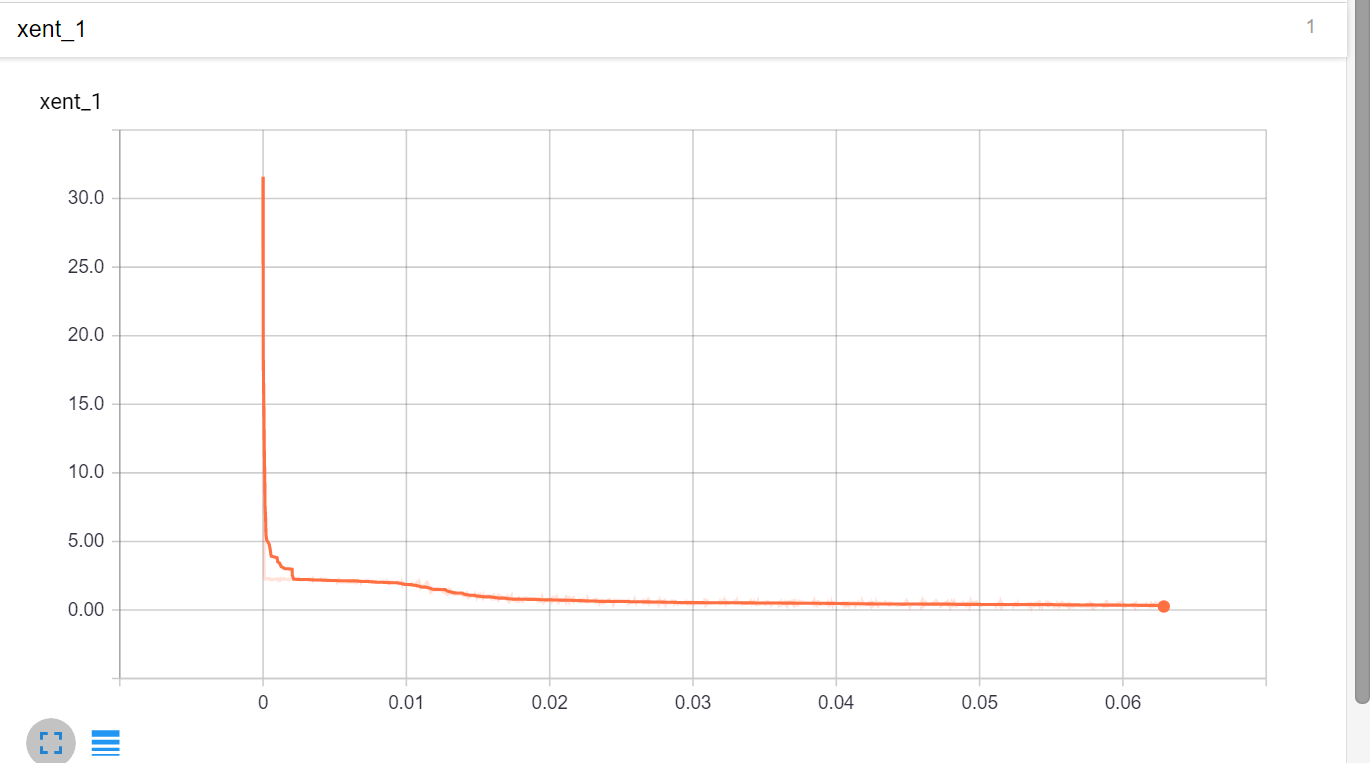

In [4]:
from IPython.display import Image
Image(filename='accuracy.png')

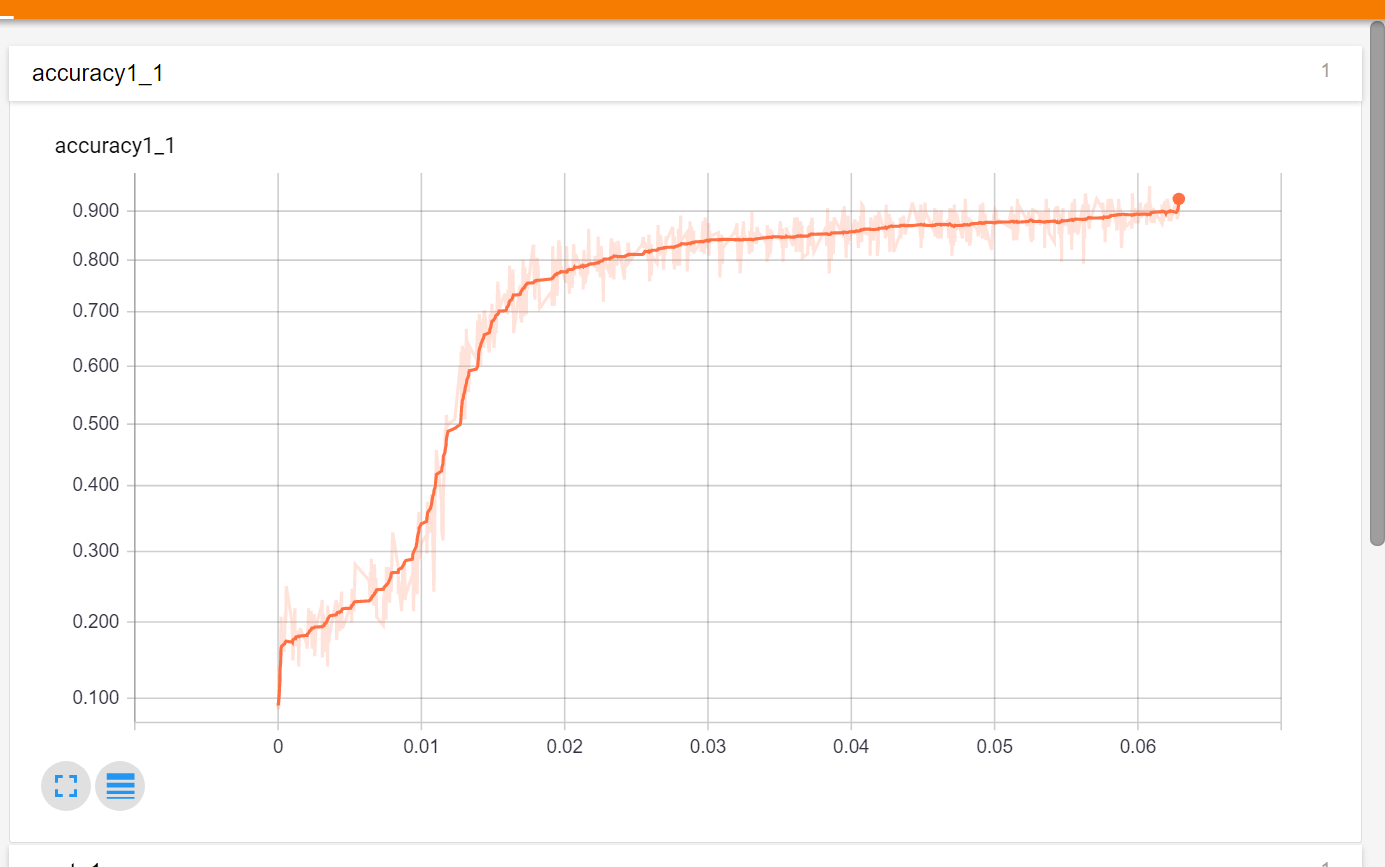

In [5]:
from IPython.display import Image
Image(filename='loss.png')

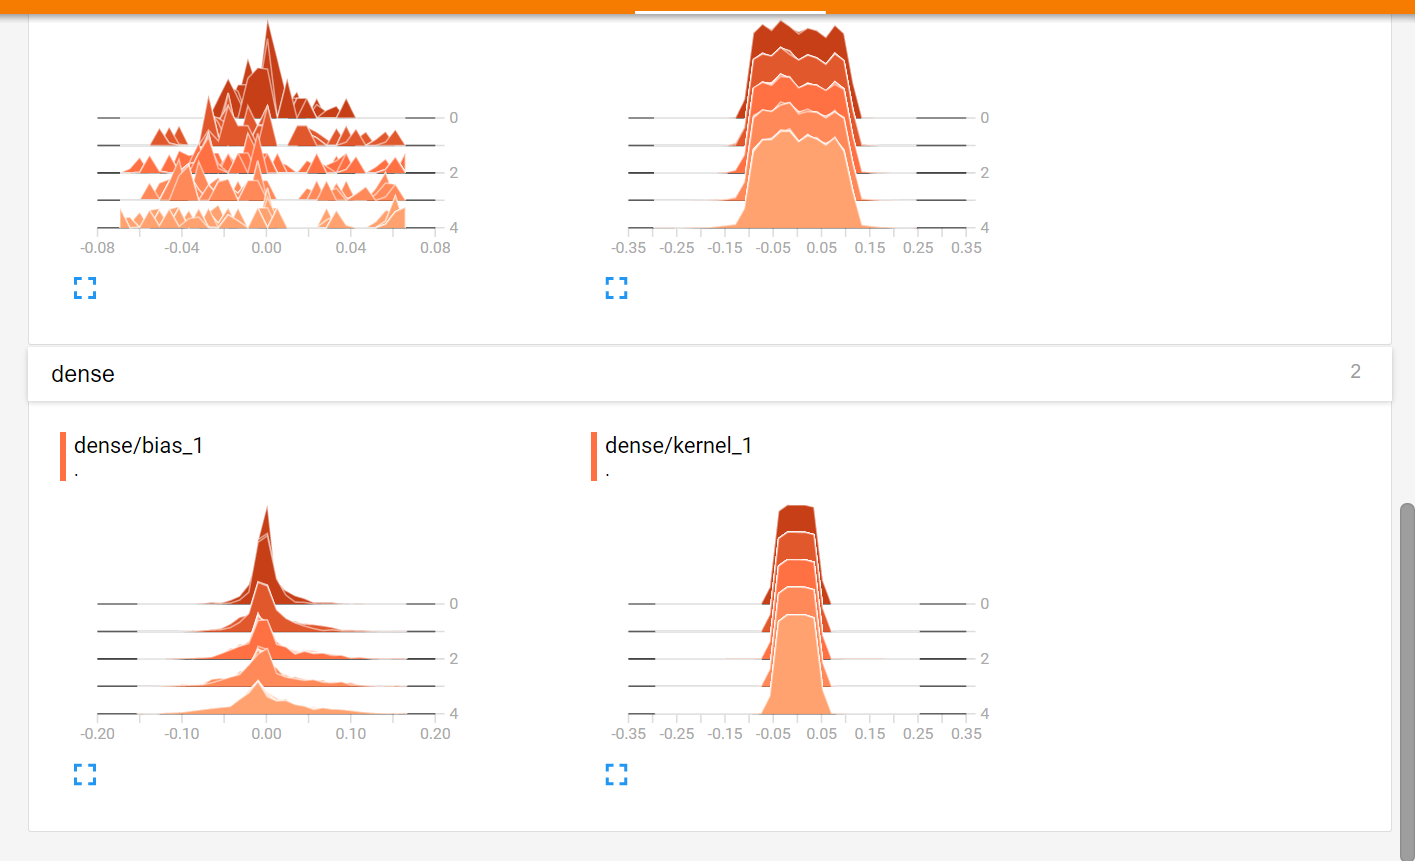

In [6]:
from IPython.display import Image
Image(filename='dense.png')

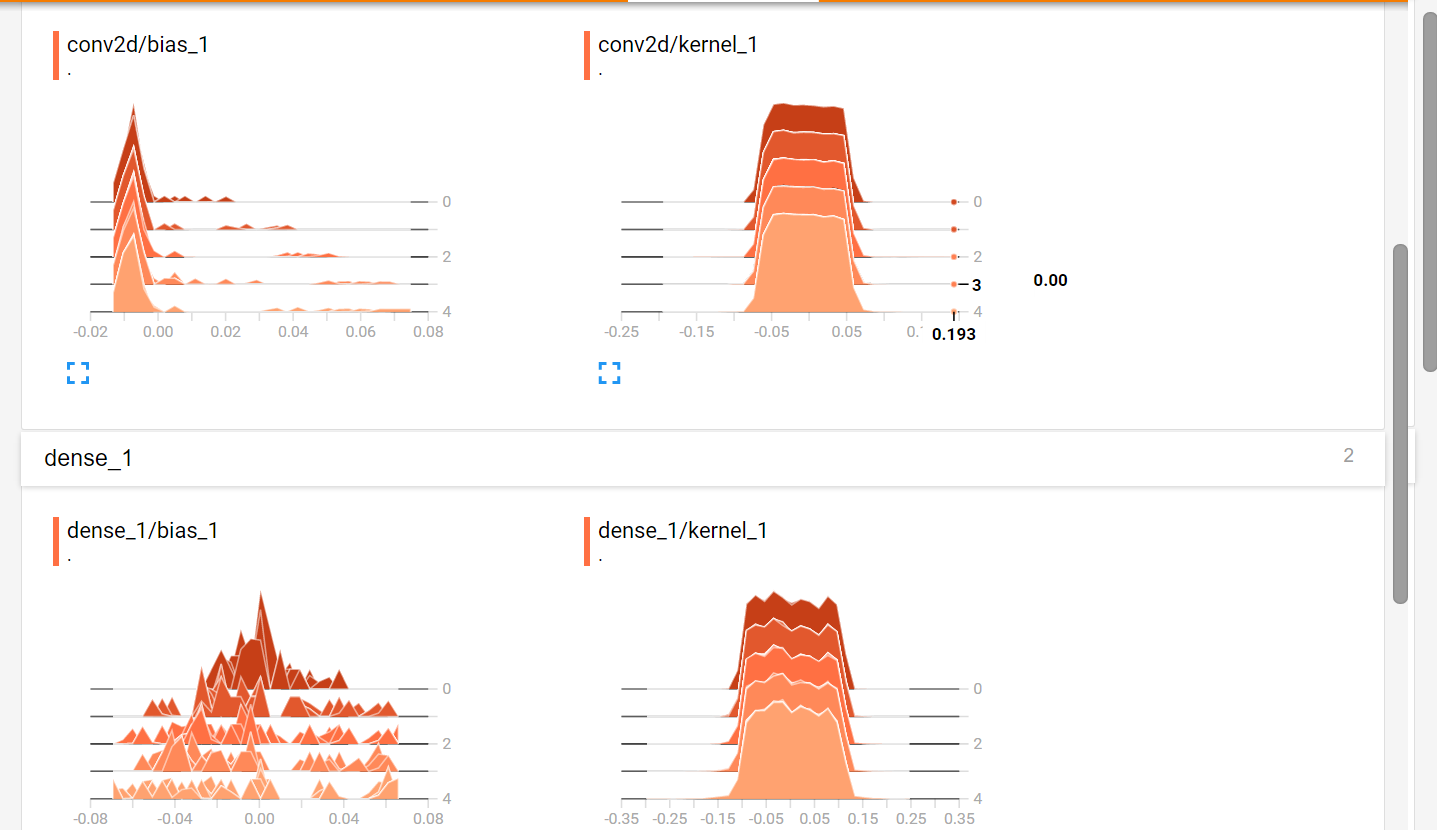

In [7]:
from IPython.display import Image
Image(filename='conv1.png')

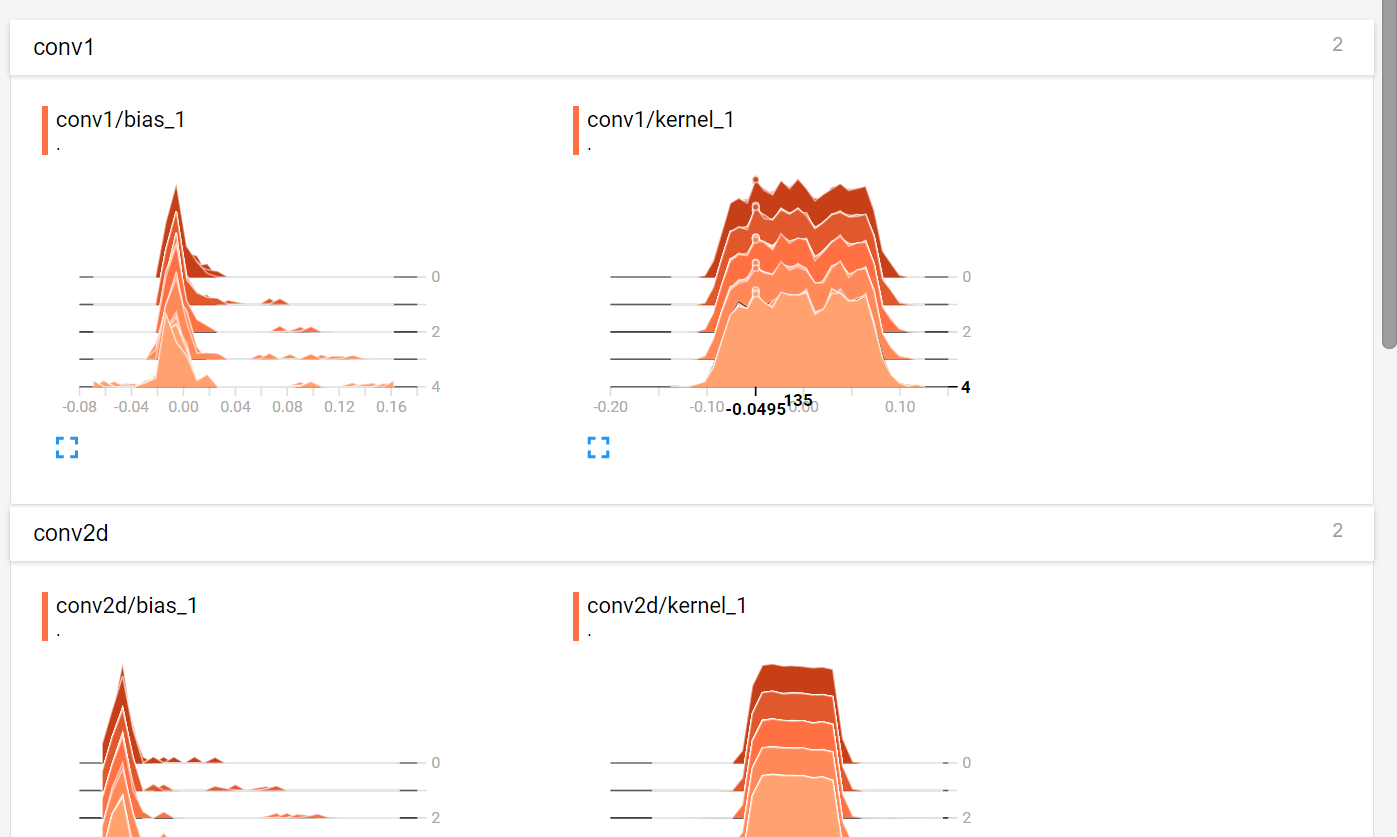

In [8]:
from IPython.display import Image
Image(filename='conv1main.png')

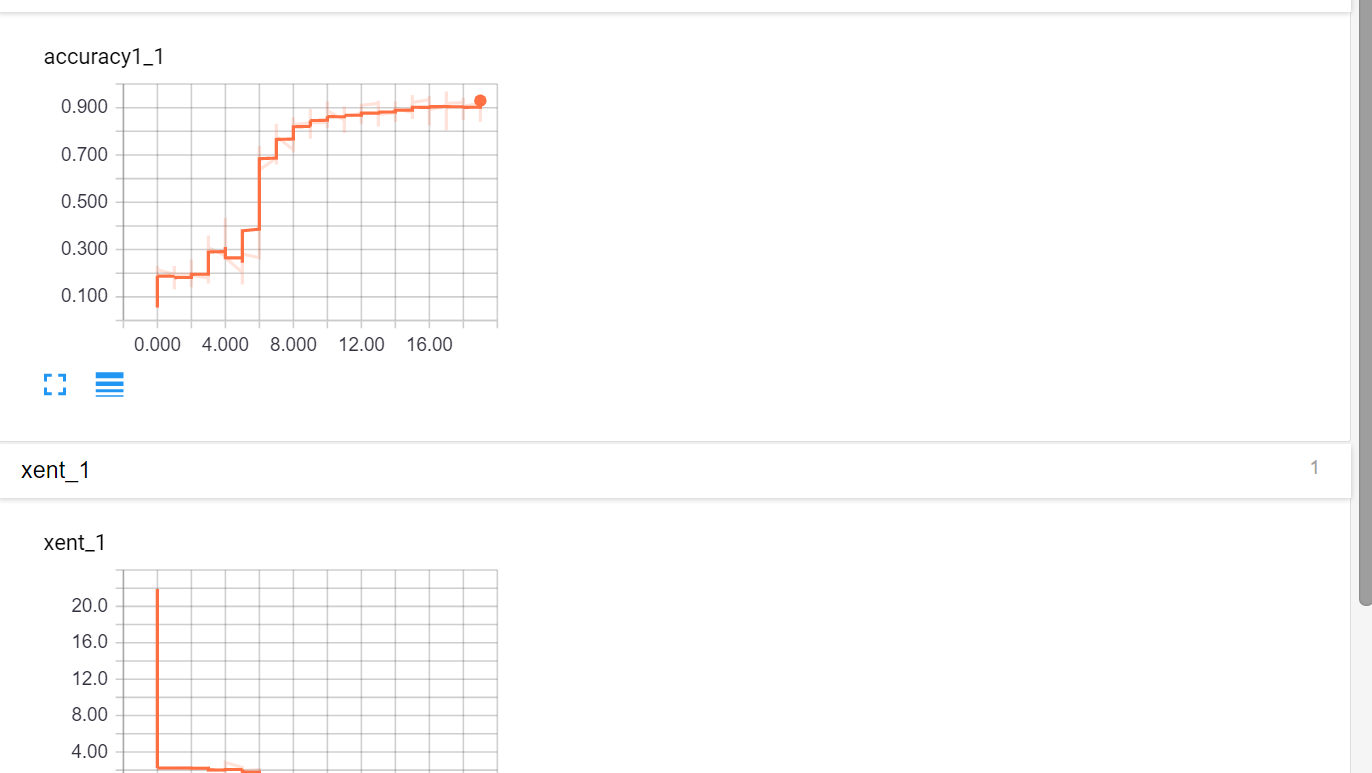

In [9]:
from IPython.display import Image
Image(filename='steploss.png')

## Part 5: Bonus
(20 points)

### Q5.1 SVHN Net ++
Improve the accuracy of SVHN Net beyond that of the provided demo: SVHN Net ++.

<img src="/usr4/dlearn/chhari/Documents/pset4/accuracy.png">


In [8]:
import copy
import os
import math
import numpy as np
import scipy
import scipy.io

from six.moves import range

import read_data

@read_data.restartable
def svhn_dataset_generator(dataset_name, batch_size):
    assert dataset_name in ['train', 'test']
    assert batch_size > 0 or batch_size == -1  # -1 for entire dataset
    
    path = './svhn_mat/' # path to the SVHN dataset you will download in Q1.1
    file_name = '%s_32x32.mat' % dataset_name
    file_dict = scipy.io.loadmat(os.path.join(path, file_name))
    X_all = file_dict['X'].transpose((3, 0, 1, 2))
    y_all = file_dict['y']
    data_len = X_all.shape[0]
    batch_size = batch_size if batch_size > 0 else data_len
    
    X_all_padded = np.concatenate([X_all, X_all[:batch_size]], axis=0)
    y_all_padded = np.concatenate([y_all, y_all[:batch_size]], axis=0)
    y_all_padded[y_all_padded == 10] = 0
    
    for slice_i in range(int(math.ceil(data_len / batch_size))):
        idx = slice_i * batch_size
        X_batch = X_all_padded[idx:idx + batch_size]
        y_batch = np.ravel(y_all_padded[idx:idx + batch_size])
        yield X_batch, y_batch
import tensorflow as tf

def cnn_map(x_):
    conv1 = tf.layers.conv2d(
            inputs=x_,
            filters=512,  # number of filters
            kernel_size=[8,8],
            padding="same",
            activation=tf.nn.relu,name = 'conv1')
    
    pool1 = tf.layers.max_pooling2d(inputs=conv1, 
                                    pool_size=[2, 2], 
                                    strides=2)  # convolution stride

    conv2 = tf.layers.conv2d(
            inputs=pool1,
            filters=256, # number of filters
            kernel_size=[8,8],
            padding="same",
            activation=tf.nn.relu)
    
    pool2 = tf.layers.max_pooling2d(inputs=conv2, 
                                    pool_size=[2, 2], 
                                    strides=2)  # convolution stride
        
    conv3  = tf.layers.conv2d(
            inputs=x_,
            filters=128,  # number of filters
            kernel_size=[8, 8],
            padding="same",
            activation=tf.nn.relu,name = 'conv3')
    pool3 = tf.layers.max_pooling2d(inputs=conv2, 
                                    pool_size=[2, 2], 
                                    strides=2)  # convolution stride
    conv4  = tf.layers.conv2d(
            inputs=x_,
            filters=128,  # number of filters
            kernel_size=[8, 8],
            padding="same",
            activation=tf.nn.relu,name = 'conv4')
    pool4 = tf.layers.max_pooling2d(inputs=conv2, 
                                    pool_size=[2, 2], 
                                    strides=2)

    pool_flat = tf.contrib.layers.flatten(pool4, scope='pool2flat')
    dense = tf.layers.dense(inputs=pool_flat, units=500, activation=tf.nn.relu)
    logits = tf.layers.dense(inputs=dense, units=10)
    
        
    return logits


def apply_classification_loss(model_function):
    with tf.Graph().as_default() as g:
        with tf.device("/gpu:0"):  # use gpu:0 if on GPU
            x_ = tf.placeholder(tf.float32, [None, 32, 32, 3],name='x_input')
            y_ = tf.placeholder(tf.int32, [None],name='y_input')
            y_logits = model_function(x_)
            
            y_dict = dict(labels=y_, logits=y_logits)
            losses = tf.nn.sparse_softmax_cross_entropy_with_logits(**y_dict)
            with tf.name_scope("xent"):
                cross_entropy_loss = tf.reduce_mean(losses)
            trainer = tf.train.AdamOptimizer(learning_rate=0.01, beta1=0.9, beta2=0.999, epsilon=1e-06)            
            train_op = trainer.minimize(cross_entropy_loss)
            
            y_pred = tf.argmax(tf.nn.softmax(y_logits), dimension=1)
            with tf.name_scope("accuracy1"):
                correct_prediction = tf.equal(tf.cast(y_pred, tf.int32), y_)
                accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
                
    
    model_dict = {'graph': g, 'inputs': [x_, y_], 'train_op': train_op,
                  'accuracy': accuracy, 'loss': cross_entropy_loss}
    
    return model_dict

def train_model(model_dict, dataset_generators, epoch_n, print_every):
    with model_dict['graph'].as_default(), tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        
        for epoch_i in range(epoch_n):
            for iter_i, data_batch in enumerate(dataset_generators['train']):
                train_feed_dict = dict(zip(model_dict['inputs'], data_batch))
                sess.run(model_dict['train_op'], feed_dict=train_feed_dict)
                
                if iter_i % print_every == 0:
                    collect_arr = []
                    for test_batch in dataset_generators['test']:
                        test_feed_dict = dict(zip(model_dict['inputs'], test_batch))
                        to_compute = [model_dict['loss'], model_dict['accuracy']]
                        collect_arr.append(sess.run(to_compute, test_feed_dict))
                    averages = np.mean(collect_arr, axis=0)
                    fmt = (epoch_i, iter_i, ) + tuple(averages)
                    print('epoch {:d} iter {:d}, loss: {:.3f}, '
                          'accuracy: {:.3f}'.format(*fmt))
print(1)


dataset_generators = {
        'train': svhn_dataset_generator('train', 256),
        'test': svhn_dataset_generator('test', 256)
}
    
model_dict = apply_classification_loss(cnn_map)
train_model(model_dict, dataset_generators, epoch_n=100, print_every=50)

1
epoch 0 iter 0, loss: 1900811.625, accuracy: 0.196
epoch 0 iter 50, loss: 2.245, accuracy: 0.196
epoch 0 iter 100, loss: 2.236, accuracy: 0.196
epoch 0 iter 150, loss: 2.236, accuracy: 0.196
epoch 0 iter 200, loss: 2.235, accuracy: 0.196
epoch 0 iter 250, loss: 2.226, accuracy: 0.196
epoch 1 iter 0, loss: 2.227, accuracy: 0.196
epoch 1 iter 50, loss: 2.224, accuracy: 0.196
epoch 1 iter 100, loss: 2.224, accuracy: 0.196
epoch 1 iter 150, loss: 2.224, accuracy: 0.196
epoch 1 iter 200, loss: 2.224, accuracy: 0.196
epoch 1 iter 250, loss: 2.224, accuracy: 0.196
epoch 2 iter 0, loss: 2.226, accuracy: 0.196
epoch 2 iter 50, loss: 2.224, accuracy: 0.196
epoch 2 iter 100, loss: 2.224, accuracy: 0.196
epoch 2 iter 150, loss: 2.224, accuracy: 0.196
epoch 2 iter 200, loss: 2.224, accuracy: 0.196
epoch 2 iter 250, loss: 2.224, accuracy: 0.196
epoch 3 iter 0, loss: 2.226, accuracy: 0.196
epoch 3 iter 50, loss: 2.224, accuracy: 0.196
epoch 3 iter 100, loss: 2.224, accuracy: 0.196
epoch 3 iter 150,